# Chapter 4.1 - 영어 텍스트 분류, P145 

## Load data

In [4]:
# For M1 macs: https://cpuu.postype.com/post/9091007
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
#from tensorflow.python.compiler.mlcompute import mlcompute
#mlcompute.set_mlc_device(device_name='gpu')

%reset

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

DATA_PATH = "./word2vec-nlp-tutorial/"

In [5]:
df_train = pd.read_csv(DATA_PATH + "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
df_test = pd.read_csv(DATA_PATH + "testData.tsv", header=0, delimiter="\t", quoting=3)

df_train.head()
df_test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


## Preprocessing

In [6]:
import re
import json
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [7]:
# Regular Expression
# Remove HTML tag
# Lower case and split to each words
# Remove stopwords
# Make splited words to sentences

def preprocessing(text):
    regular_expression1 = "^[a-zA-Z0-9]"

    text = BeautifulSoup(text, 'html5lib').get_text()
    text = re.sub(regular_expression1, " ", text)

    words = text.lower().split()
    stop_words = stopwords.words('english')
    words = [w for w in words if not w in stop_words]

    clean_text = ' '.join(words)

    return clean_text

In [8]:
for i in tqdm(range(0, df_train.shape[0])):
    df_train['review'][i] = preprocessing(df_train['review'][i])

for i in tqdm(range(0, df_test.shape[0])):
    df_test['review'][i] = preprocessing(df_test['review'][i])

#df_train.head()
#df_test.head()

  0%|          | 0/25000 [00:00<?, ?it/s]<ipython-input-8-b288b68495cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['review'][i] = preprocessing(df_train['review'][i])
100%|██████████| 25000/25000 [00:29<00:00, 856.31it/s]


In [9]:
# Integer index

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['review'])
train_sequences = tokenizer.texts_to_sequences(df_train['review'])
test_sequences = tokenizer.texts_to_sequences(df_test['review'])

#print(text_sequences[0])

In [10]:
# Make vocabulary

vocab = tokenizer.word_index
vocab["<PAD>"] = 0

datas = {}
datas['vocab'] = vocab
datas['vocab_size'] = len(vocab)

#print(datas['vocab'])
#print(datas['vocab_size'])

In [11]:
# Padding for train data & test data

MAX_SEQUENCE_LENGTH = 180

train_inputs = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_train['sentiment'])

test_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding='post')
test_id = np.array(df_test['id'])

#print(train_inputs.shape)
#print(type(train_inputs))
#print(train_inputs)

#print(train_labels.shape)
#print(type(train_labels))
#print(train_labels)

## RNN Model

In [12]:
# Seed 

import tensorflow as tf

SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

### Define hyperparameter

In [13]:
model_name = 'RNN_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_inputs.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': datas['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension': 1}

### Model implementation

In [14]:
class RNNclassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNclassifier, self).__init__(name=kargs['model_name'])

        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm1 = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units=kargs['dense_dimension'], activation=tf.keras.activations.relu)
        self.fc2 = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)

        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x

### Generate model instance

In [15]:
model = RNNclassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

### Model learning

> Memo 
>
> numpy 1.20 이상은 뭔가 [에러](https://stackoverflow.com/questions/58479556/notimplementederror-cannot-convert-a-symbolic-tensor-2nd-target0-to-a-numpy)가 있음
>
> 난 pip로 Build 안돼서 conda로 1.19.5 설치했음
>
> numpy array 말고 Tensor가 들어가야하는듯 -> 꼭 그건 아니고 버전만 맞추면 됨

In [16]:
#from tensorflow.python.ops.math_ops import reduce_prod
from tensorflow.math import reduce_prod

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2)

checkpoint_path = DATA_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    pass
else:
    os.makedirs(checkpoint_dir, exist_ok=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

#train_inputs = tf.convert_to_tensor(train_inputs)
#train_labels = tf.convert_to_tensor(train_labels)

history = model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - 76s 426ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6929 - val_accuracy: 0.5080

Epoch 00001: val_accuracy improved from -inf to 0.50800, saving model to ./word2vec-nlp-tutorial/RNN_classifier_en/weights.h5
Epoch 2/5
176/176 [==============================] - 82s 468ms/step - loss: 0.6901 - accuracy: 0.5180 - val_loss: 0.4505 - val_accuracy: 0.8068

Epoch 00002: val_accuracy improved from 0.50800 to 0.80680, saving model to ./word2vec-nlp-tutorial/RNN_classifier_en/weights.h5
Epoch 3/5
176/176 [==============================] - 83s 474ms/step - loss: 0.3670 - accuracy: 0.8457 - val_loss: 0.3017 - val_accuracy: 0.8684

Epoch 00003: val_accuracy improved from 0.80680 to 0.86840, saving model to ./word2vec-nlp-tutorial/RNN_classifier_en/weights.h5
Epoch 4/5
176/176 [==============================] - 84s 477ms/step - loss: 0.1946 - accuracy: 0.9300 - val_loss: 0.2998 - val_accuracy: 0.8740

Epoch 00004: val_accuracy improved f

### Show results

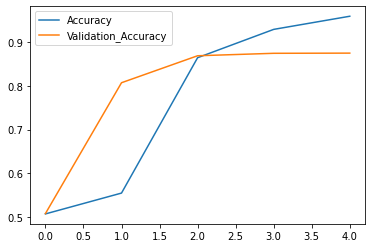

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label = "Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation_Accuracy")

plt.legend()
plt.show()

### Prediction & Submit to Kaggle

> Memo
>
> [AttributeError: 'str' object has no attribute 'decode'](https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi)
>
> h5py package를 2.10.0 버전으로 

In [18]:
SAVE_FILE_NAME = 'weight.h5'
DATA_OUT_PATH = "./word2vec-nlp-tutorial/data_out/"

model.load_weights(os.path.join(checkpoint_path))

In [19]:
predictions = model.predict(test_inputs, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

print(predictions)

[0.99714524 0.00930078 0.42532393 ... 0.67809004 0.9187481  0.01261904]


In [20]:
def configure(x):
    if x >= 0.5:
        return 1
    else:
        return 0

for i in tqdm(range(0, predictions.shape[0])):
    predictions[i] = configure(predictions[i])

predictions = np.array(predictions).astype('int8')
print(predictions)

100%|██████████| 25000/25000 [00:00<00:00, 333368.09it/s][1 0 0 ... 1 1 0]



In [21]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH+'movie_review_result_rnn.csv', index=False, quoting=3)